In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Preparation**

Based on the analysis 02 Module, the Log Pearson 3 is choosen for next step of the analysis.

In [ ]:
df = pd.DataFrame(
[[2.0, 86.0],
 [5.0, 111.1],
 [10.0, 132.4],
 [25.0, 165.4],
 [50.0, 194.8],
 [100.0, 228.7],
 [200.0, 267.9],
 [500.0, 329.4],
 [1000.0, 384.6]],
 columns=["Return Period","Log-Pearson III"]) # Log-Pearson III = Rainfall Return Period

df # based data from module 02

,Return Period,Log-Pearson III
0,2.0,86.0
1,5.0,111.1
2,10.0,132.4
3,25.0,165.4
4,50.0,194.8
5,100.0,228.7
6,200.0,267.9
7,500.0,329.4
8,1000.0,384.6


# Hourly Rain Distribution<br>


Program Using PSA 007

In [ ]:
def hourly_rain_dist(df,user_input):
  six_hour = pd.DataFrame({
      "time" : [1, 2, 3, 4, 5, 6],
      "R/Rt" : [0.05, 0.1, 0.6, 0.16, 0.0599999999999999, 0.03]
  })

  twelve_hour = pd.DataFrame({
      "time" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
      "R/Rt" : [0.02, 0.02, 0.03, 0.05, 0.09, 0.45, 0.15, 0.07, 0.05, 0.0299999999999999, 0.03, 0.01]
  })

  twentyfour_hour = pd.DataFrame({
      "time" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
      "R/Rt" : [0.0075, 0.0075, 0.0125, 0.0125, 0.015, 0.015, 0.025, 0.025, 0.035, 0.05, 0.09, 0.33, 0.12, 0.0600000000000001, 0.0399999999999999, 0.035, 0.025, 0.025, 0.0149999999999999, 0.015, 0.0125000000000001, 0.0125, 0.00750000000000006, 0.00749999999999995]
  })

  rain_distribution = { # Hourly Distribution Option
      "6-H": six_hour,
      "12-H": twelve_hour,
      "24-H": twentyfour_hour
  }

  user_input = user_input # Choose the daily rainfall duration
  df_dur = rain_distribution[user_input]
  df_dur[df["Return Period"]] = (df["Log-Pearson III"].values.reshape(1,-1) * df_dur["R/Rt"].values.reshape(-1,1)).round(1) # (1,-1) -> From Column to Row & (-1,1) From Row to Column

  return_periods = df_dur.columns[2:]

  x = np.arange(len(df_dur["time"]))+1  # base
  bar_width = 0.08  # width
  n = len(return_periods)  # number of return periods

  # Plot
  plt.figure(figsize=(10, 3))
  for i, period in enumerate(return_periods):
    plt.bar(x + i * bar_width, df_dur[period], width=bar_width, label=f"T={period}")

  plt.xlabel("Duration Step (hour)")
  plt.ylabel("Rainfall (mm)")
  plt.title(f"Hourly Rainfall : {user_input}")
  plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
  plt.xticks(np.arange(min(x), max(x)+1, 1))
  plt.legend()
  plt.show()

  return df_dur

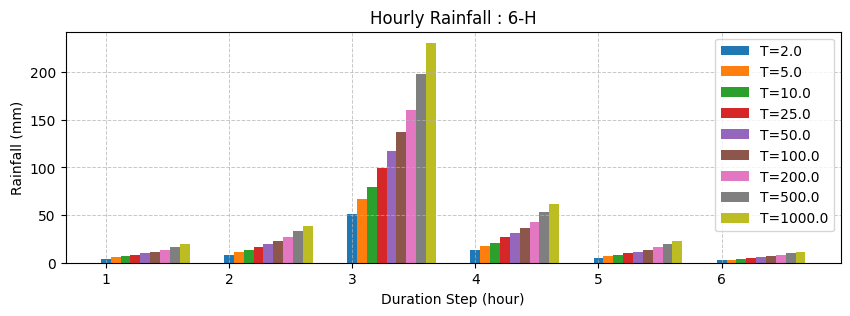

,time,R/Rt,2.0,5.0,10.0,25.0,50.0,100.0,200.0,500.0,1000.0
0,1,0.05,4.3,5.6,6.6,8.3,9.7,11.4,13.4,16.5,19.2
1,2,0.10,8.6,11.1,13.2,16.5,19.5,22.9,26.8,32.9,38.5
2,3,0.60,51.6,66.7,79.4,99.2,116.9,137.2,160.7,197.6,230.8
3,4,0.16,13.8,17.8,21.2,26.5,31.2,36.6,42.9,52.7,61.5
4,5,0.06,5.2,6.7,7.9,9.9,11.7,13.7,16.1,19.8,23.1
5,6,0.03,2.6,3.3,4.0,5.0,5.8,6.9,8.0,9.9,11.5


In [ ]:
hourly_rain_dist(df,'6-H')

# Losses Method (Curve Number)

In [ ]:
def curve_number_losses(CN):
  S = (25400-254*CN)/CN
  Ia = 0.2 * S

  return_periods = np.array([2,5,10,25,50,100,200,500,1000])

  results_losses = {}

  for i in return_periods:
    df_temp = df_dur[['time',i]].copy()
    df_temp["Cum"] = df_temp[i].cumsum()
    df_temp["Ia"] = np.where(df_temp["Cum"] > Ia, Ia, df_temp["Cum"]).round(2)
    df_temp["Pe"] = ((df_temp["Cum"]-df_temp["Ia"])**2/(df_temp["Cum"]-df_temp["Ia"] + S)).round(2)
    df_temp["Cum Excess"] = df_temp["Cum"] - df_temp["Ia"] - df_temp["Pe"]
    df_temp["Excess Rainfall"] = df_temp["Pe"].diff().fillna(0)
    df_temp["Loss"] = df_temp[i] - df_temp["Excess Rainfall"]

    sum_row = pd.DataFrame(df_temp.iloc[:, 1:].sum()).transpose()  # sum semua kolom kecuali 'time'
    sum_row["time"] = "Total"  # Tambahkan keterangan 'Total' pada kolom 'time'
    sum_row = sum_row[df_temp.columns]
    df_temp = pd.concat([df_temp, sum_row], ignore_index=True)

    results_losses[i] = df_temp
  return results_losses

In [ ]:
CN = 95 # User Input of CN

results_losses = curve_number_losses(CN)

In [ ]:
results_losses[50] # Pick the 50 Return Period

,time,50.0,Cum,Ia,Pe,Cum Excess,Excess Rainfall,Loss
0,1,9.7,9.7,2.67,2.42,4.61,0.00,9.70
1,2,19.5,29.2,2.67,17.64,8.89,15.22,4.28
2,3,116.9,146.1,2.67,131.20,12.23,113.56,3.34
3,4,31.2,177.3,2.67,162.21,12.42,31.01,0.19
4,5,11.7,189.0,2.67,173.86,12.47,11.65,0.05
5,6,5.8,194.8,2.67,179.63,12.50,5.77,0.03
6,Total,194.8,746.1,16.02,666.96,63.12,177.21,17.59


In [ ]:
results_losses

{np.int64(2):     time   2.0    Cum     Ia      Pe  Cum Excess  Excess Rainfall   Loss
 0      1   4.3    4.3   2.67    0.18        1.45             0.00   4.30
 1      2   8.6   12.9   2.67    4.43        5.80             4.25   4.35
 2      3  51.6   64.5   2.67   50.84       10.99            46.41   5.19
 3      4  13.8   78.3   2.67   64.27       11.36            13.43   0.37
 4      5   5.2   83.5   2.67   69.36       11.47             5.09   0.11
 5      6   2.6   86.1   2.67   71.91       11.52             2.55   0.05
 6  Total  86.1  329.6  16.02  260.99       52.59            71.73  14.37,
 np.int64(5):     time    5.0    Cum     Ia      Pe  Cum Excess  Excess Rainfall   Loss
 0      1    5.6    5.6   2.67    0.53        2.40             0.00   5.60
 1      2   11.1   16.7   2.67    7.18        6.85             6.65   4.45
 2      3   66.7   83.4   2.67   69.26       11.47            62.08   4.62
 3      4   17.8  101.2   2.67   86.76       11.77            17.50   0.30
 4    

Excess Rainfall means Effective Rainfall

# Data Extraction

In [ ]:
import zipfile
import os
csv_files = []
for period, df in results_losses.items():
    filename = f"results_losses{period}.csv"
    df.to_csv(filename, index=False)
    csv_files.append(filename)

zip_filename = "results_losses.zip"
with zipfile.ZipFile(zip_filename,"w") as zipf:
  for file in csv_files:
    zipf.write(file)
    os.remove(file)

print(f"All files saved in {zip_filename} ")

from google.colab import files
files.download("results_losses.zip")

All files saved in results_losses.zip 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a href="https://www.linkedin.com/in/iqbalfauzanh/"><img src="https://img.shields.io/badge/-© 2025 Iqbal Fauzan Herlambang-417DAC?style=for-the-badge&logoColor=white"/></a>